### CryptoCurrency (BTC-USD) Forecasting

In [1]:
import tensorflow as tf
import os
import warnings 
import time
import pandas as pd
import random
import gc
import numpy as np
import time
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import meanabs, rmse
from statsmodels.tools.eval_measures import meanabs
from sklearn.preprocessing import MinMaxScaler
import gc
import math as mt
from IPython.display import display
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Data Extraction and Preprocessing | With 1 month data (1 minute unit-stick)  

In [2]:
df_asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
print('df_asset_details: ',df_asset_details.shape)
df_train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv').iloc[:350000] #~3 months worth of data-points
print('train_shape: ', df_train.shape)

df_asset_details:  (14, 3)
train_shape:  (350000, 10)


In [3]:
display(df_asset_details)

target_coins = ['Bitcoin', 'Ethereum', 'Binance Coin']

df_asset_dict = {k : v for k, v in zip(df_asset_details['Asset_Name'].values, df_asset_details['Asset_ID'].values)}
df_btc = df_train[df_train['Asset_ID'] == df_asset_dict[target_coins[0]]]
df_eth = df_train[df_train['Asset_ID'] == df_asset_dict[target_coins[1]]]
df_bnb = df_train[df_train['Asset_ID'] == df_asset_dict[target_coins[-1]]]

print('BTC-Len: ', len(df_btc), ', ETH-Len: ', len(df_eth), ', BNB-Len: ', len(df_bnb))

print()
display(df_btc.head(5))

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


BTC-Len:  44406 , ETH-Len:  44406 , BNB-Len:  44100



,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


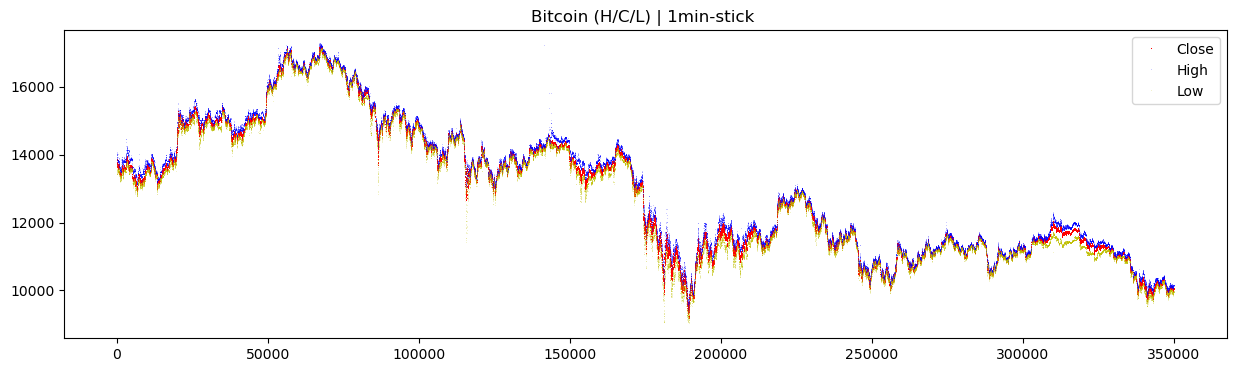

In [4]:
fig, axs = plt.subplots(1, 1, figsize = (15, 4))

axs.plot(df_btc.Close, ',r', label = 'Close')
axs.plot(df_btc.High, ',b', alpha = 0.2, label = 'High')
axs.plot(df_btc.Low, ',y', alpha = 0.2, label = 'Low')

axs.set_title(target_coins[0] + ' (H/C/L) | 1min-stick ')

plt.legend()
plt.show()

The prior slicing of the total sample size allows us to compare predictions with OOD close prices.

In [5]:
total_sample_size = len(df_btc)
print('total_sample_size: ', total_sample_size)

pred_sample_size = 5000
train_sample_size = total_sample_size - pred_sample_size

print('train_sample_size: ', train_sample_size, ', pred_sample_size: ', pred_sample_size)

total_sample_size:  44406
train_sample_size:  39406 , pred_sample_size:  5000


(39406, 10) (4999, 10)


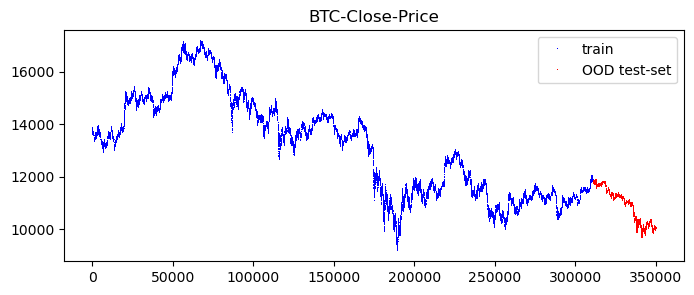

In [6]:
df_btc_train, df_btc_test = df_btc.iloc[:train_sample_size], df_btc.iloc[train_sample_size+1:]
print(df_btc_train.shape, df_btc_test.shape)

fig, axs = plt.subplots(1, 1, figsize = (8, 3))

axs.plot(df_btc_train.index, df_btc_train.Close, ',b', label = 'train')
axs.plot(df_btc_test.index, df_btc_test.Close, ',r', label = 'OOD test-set')
axs.set_title('BTC-Close-Price')

plt.legend()
plt.show()

#### Custom-scaling

In [ ]:
def min_max_scale(data, new):
    
    new_min, new_max = new
    
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)

    scaled_data = (data - min_values) * (new_max - new_min) / (max_values - min_values) + new_min

    return scaled_data, min_values, max_values

def descale(scaled_data, new_min, new_max):
    
    min_values = np.min(scaled_data, axis=0)
    max_values = np.max(scaled_data, axis=0)

    original_data = (scaled_data - min_values) * (new_max - new_min) / (max_values - min_values) + new_min
    
    return original_data

In [7]:
x_obs_close = df_btc_train.Close.to_numpy()
x_obs_close_test = df_btc_test.Close.to_numpy()

x_obs_all = df_btc_train[['Count', 'Open', 'High', 'Low', 'Volume', 'Close']].to_numpy()
x_obs_all_test = df_btc_test[['Count', 'Open', 'High', 'Low', 'Volume', 'Close']].to_numpy()

print('Close-Price: ', x_obs_close.shape, x_obs_close_test.shape)
print('Multi-Feature-Space: ', x_obs_all.shape, x_obs_all_test.shape)

train_split, test_split = 0.70, 0.30
train_max = round(train_split * x_obs_close.shape[0])
val_max = (1 - train_split) * x_obs_close.shape[0]
test_max = round(test_split * val_max)
val_max = round(val_max - test_max)

Close-Price:  (39406,) (4999,)
Multi-Feature-Space:  (39406, 6) (4999, 6)


#### PreProcessing

In [8]:
scaler_close = StandardScaler()
scaler_all = StandardScaler()

norm_close = Normalizer()
norm_all = Normalizer()

min: 9174.665, max: 17179.134
close-train-shape:  (39406, 1)
scaled-min: [-2.11633976], scaled-max: [2.15369644]
Descaled:  9174.665 ,  17179.134

multi-train-shape:  (39406, 6)
scaled-min: 9174.665, scaled-max: 17179.134


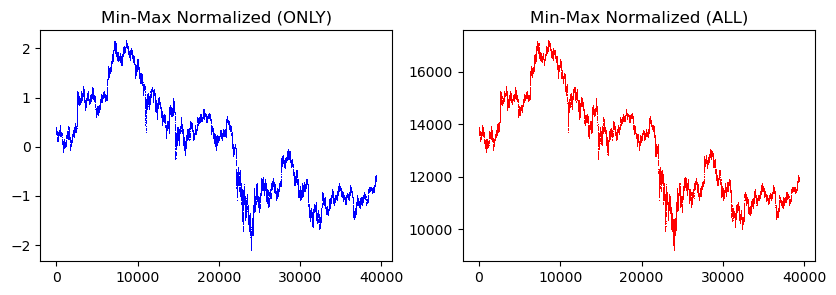

In [9]:
### Need to perform min-max scaling on the entire dataspace with the train_set distribution
### information only
### Assuming Lower Volatitly Levels for BTC

new = 0, 1

print(f'min: {min(x_obs_close)}, max: {max(x_obs_close)}')

# x_obs_close_scaled, min_og, max_og = min_max_scale(x_obs_close, new)

x_obs_close_scaled = scaler_close.fit_transform(x_obs_close.reshape(-1, 1))
x_obs_close_scaled = x_obs_close_scaled.reshape(-1, 1)

# x_obs_close_scaled = norm_close.fit_transform(x_obs_close.reshape(-1, 1))
# x_obs_close_scaled = x_obs_close_scaled.reshape(-1, 1)

# x_obs_close_test_scaled, min_og, max_og = min_max_scale(x_obs_close_test, new)
# x_obs_close_test_scaled = x_obs_close_test_scaled.reshape(-1, 1)

print('close-train-shape: ', x_obs_close_scaled.shape)
print(f'scaled-min: {min(x_obs_close_scaled)}, scaled-max: {max(x_obs_close_scaled)}')

# x_obs_descaled = descale(x_obs_close_scaled, min_og, max_og)

x_obs_descaled = scaler_close.inverse_transform(x_obs_close_scaled)
print('Descaled: ', np.min(x_obs_descaled), ', ', np.max(x_obs_descaled))
del x_obs_descaled
gc.collect()

'----------------------------------------------------------------------'

''' For Multi-Feature dataspace might need to use event-based normalization - So need to add a inside layer instead of preprocessing '''

# x_obs_all_scaled, min_og, max_og = min_max_scale(x_obs_all, new)

# x_obs_all_scaled = scaler_all.fit_transform(x_obs_all)
# x_obs_all_scaled = x_obs_all_scaled.reshape(-1, x_obs_all.shape[-1])

# x_obs_all_scaled = norm_all.fit_transform(x_obs_all)
# x_obs_all_scaled = x_obs_all_scaled.reshape(-1, x_obs_all.shape[-1])

# x_obs_all_test_scaled, min_og, max_og = min_max_scale(x_obs_all_test, new)
# x_obs_all_test_scaled = x_obs_all_test_scaled.reshape(-1, x_obs_all.shape[-1])

x_obs_all_scaled = x_obs_all

print()
print('multi-train-shape: ', x_obs_all_scaled.shape)
print(f'scaled-min: {min(np.ravel(x_obs_all_scaled[:,-1]))}, scaled-max: {max(np.ravel(x_obs_all_scaled[:, -1]))}')

# x_obs_descaled = descale(x_obs_all_scaled, min_og, max_og)

# x_obs_all_descaled = scaler_all.inverse_transform(x_obs_all_scaled)
# print('Descaled: ', np.min(x_obs_all_descaled), ', ', np.max(x_obs_all_descaled))
# del x_obs_all_descaled
# gc.collect()

fig, axs = plt.subplots(1, 2, figsize = (10, 3))

axs[0].plot(x_obs_close_scaled, ',b')
axs[0].set_title('Min-Max Normalized (ONLY)')

axs[1].plot(x_obs_all_scaled[:, -1], ',r')
axs[1].set_title('Min-Max Normalized (ALL)')

plt.show()

In [10]:
seed = 28
np.random.seed(seed)


def Data_func(data, past, delay, minn, maxx = None, shuffle=False, batch_size=128, rate=6):
    if maxx is None:
        maxx = len(data) - delay -1
    i = minn + past
    batch_no = 1

    while True:

        if shuffle:
            rows = np.random.randint(minn + past, maxx, size = batch_size)
        else:
            rows = np.arange(i, min(i + batch_size, maxx))
        
        i+=len(rows)
        if i + batch_size > maxx: ## when you increase the past too much this statement gets executed at the first batch creation // add more data to overcome
            break
        
        samples = np.zeros((len(rows), past // rate, data.shape[-1]))
        targets = np.zeros((len(rows),))
        cbase_preds = np.zeros((len(rows),))
    
        for j, row in enumerate(rows):
            
            indices = range(rows[j] - past, rows[j], rate) ## take every point
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay - 1][-1] ### acessing Close price HERE!
       
        if batch_no == 1:
            new_sample = samples
            new_targets = targets
            print('Ini_samples: ', samples.shape, 'Ini_targets: ', targets.shape)
        else:
            new_sample = np.concatenate([new_sample, samples], axis=0)
            new_targets = np.concatenate([new_targets, targets], axis=0)
        batch_no += 1
        
    return new_sample, new_targets

batch_size = 32
past = 360 #  6 hours in past {Localised}
delay = 0 # After 15 minute into the future
sample_rate = 5

## sampling data every (sample_rate) minute | Information Flow into the <val> and <test> set | Transforming from unit-minute chart to sample_rate minute chart
train_data_close, train_target_close = Data_func(x_obs_close_scaled, past, delay, minn = 0, maxx = train_max - 1, batch_size = batch_size, shuffle=True, rate = sample_rate)
val_data_close, val_target_close = Data_func(x_obs_close_scaled, past, delay, minn = train_max + 1, maxx = train_max + val_max - 1, batch_size = batch_size, rate = sample_rate)
test_data_close, test_target_close = Data_func(x_obs_close_scaled, past, delay, minn = train_max + val_max + 1, maxx = train_max + val_max + test_max, batch_size = batch_size, rate = sample_rate)

## sampling data every (sample_rate) minute | Information Flow into the <val> and <test> set | Transforming from unit-minute chart to sample_rate minute chart
train_data_all, train_target_all = Data_func(x_obs_all_scaled, past, delay, minn = 0, maxx = train_max - 1, batch_size = batch_size, shuffle=True, rate = sample_rate)
val_data_all, val_target_all = Data_func(x_obs_all_scaled, past, delay, minn = train_max + 1, maxx = train_max + val_max - 1, batch_size = batch_size, rate = sample_rate)
test_data_all, test_target_all = Data_func(x_obs_all_scaled, past, delay, minn = train_max + val_max + 1, maxx = train_max + val_max + test_max, batch_size = batch_size, rate = sample_rate)

print()
print(train_data_close.shape, train_target_close.shape, val_data_close.shape, val_target_close.shape, test_data_close.shape, test_target_close.shape)
print('Min-Max-Range')
print(min(np.ravel(train_data_close)), max(np.ravel(train_target_close)))
print(min(np.ravel(val_data_close)), max(np.ravel(val_target_close)))
print(min(np.ravel(test_data_close)), max(np.ravel(test_target_close)))

print()
print(train_data_all.shape, train_target_all.shape, val_data_all.shape, val_target_all.shape, test_data_all.shape, test_target_all.shape)
print('Min-Max-Range')
print(min(np.ravel(train_data_all)), max(np.ravel(train_target_all)))
print(min(np.ravel(val_data_all)), max(np.ravel(val_target_all)))
print(min(np.ravel(test_data_all)), max(np.ravel(test_target_all)))

Ini_samples:  (32, 72, 1) Ini_targets:  (32,)
Ini_samples:  (32, 72, 1) Ini_targets:  (32,)
Ini_samples:  (32, 72, 1) Ini_targets:  (32,)
Ini_samples:  (32, 72, 6) Ini_targets:  (32,)
Ini_samples:  (32, 72, 6) Ini_targets:  (32,)
Ini_samples:  (32, 72, 6) Ini_targets:  (32,)

(27168, 72, 1) (27168,) (7872, 72, 1) (7872,) (3136, 72, 1) (3136,)
Min-Max-Range
-2.1163397582895604 2.148270117703967
-1.6894465108701737 -0.07524174901125336
-1.4976848947926886 -0.5971524939974341

(27168, 72, 6) (27168,) (7872, 72, 6) (7872,) (3136, 72, 6) (3136,)
Min-Max-Range
3.61953705 17179.134
8.371813040529442 13000.840000000002
4.909308790000001 12022.483333333332


#### 2-Step PreProcessing - Normalization

In [ ]:
def inv_norm(test_target):
    test_target = np.ravel(test_target)
    test_target = test_target * std[-1]
    test_target = test_target + mean[-1]
    return test_target

In [ ]:
sample_seed = 5

fig, axs = plt.subplots(1, 3, figsize = (15, 6))

axs[1].plot(np.arange(0, len(train_data[sample_seed])), np.squeeze(train_data[sample_seed]), 'k')
axs[1].set_title(' - Scaling (1st PreProcess) - ')

axs[0].plot(np.arange(0, len(train_data[sample_seed])), inv_norm(np.squeeze(train_data[sample_seed])), 'k')
axs[0].set_title(' - Normalized (2nd PreProcess) - ')

axs[2].plot(np.arange(0, len(train_data[sample_seed])), descale(inv_norm(np.squeeze(train_data[sample_seed])), min_og, max_og), 'k')
axs[2].set_title(' - De-Scaled - ')

plt.tight_layout(pad = 2)
plt.show()

### Statistical-TS Workflow <br>

In [168]:
print('Train-Len: ', len(df_btc_train.Close))
print('Test-Len: ', len(df_btc_test.Close))

Train-Len:  39406
Test-Len:  4999


#### Local-Linear Trend Model (statsmodels) --v1

In [169]:
x_sample_train = df_btc_train.Close.iloc[-1500:] 
x_sample_test = df_btc_test.Close.iloc[:50]

print(x_sample_train.shape, x_sample_test.shape)

(1500,) (50,)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48187D+00    |proj g|=  3.74326D-03

At iterate    5    f=  4.10954D+00    |proj g|=  5.51592D-02

At iterate   10    f=  3.97873D+00    |proj g|=  5.61794D-03

At iterate   15    f=  3.89901D+00    |proj g|=  1.30892D-02

At iterate   20    f=  3.87572D+00    |proj g|=  3.19599D-03

At iterate   25    f=  3.87560D+00    |proj g|=  2.51423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     51      1     0     0   

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


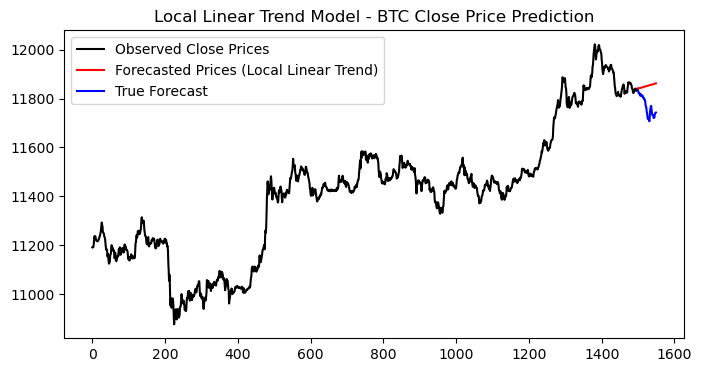

In [170]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

local_linear_model = sm.tsa.UnobservedComponents(x_sample_train, level='local linear trend')
local_linear_result = local_linear_model.fit()

print(local_linear_result.summary())

forecast_local_linear = local_linear_result.get_forecast(steps = len(x_sample_test))
forecast_local_linear_values = forecast_local_linear.predicted_mean

plt.figure(figsize=(8, 4))

xlin_1 = np.arange(0, len(x_sample_train))
xlin_2 = np.arange(len(x_sample_train), len(x_sample_train) + len(x_sample_test))

plt.plot(xlin_1, x_sample_train, label='Observed Close Prices', color = 'black')
plt.plot(xlin_2, forecast_local_linear_values, label='Forecasted Prices (Local Linear Trend)', color='red')
plt.plot(xlin_2, x_sample_test, label = 'True Forecast', color = 'blue')
plt.title('Local Linear Trend Model - BTC Close Price Prediction')
plt.legend()
plt.show()


 #### Local-Linear Trend Model --v2

In [ ]:
x_obs_scaled = x_obs_scaled[:200].reshape(-1, 1)
print(x_obs_scaled.shape)

In [ ]:
num_timesteps = len(x_obs_scaled)

def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(
      observed_time_series=approximate_unconstrained_rates)
    return tfp.sts.Sum([trend],
                     observed_time_series=approximate_unconstrained_rates)

positive_bijector = tfb.Softplus()  

approximate_unconstrained_rates = positive_bijector.inverse(tf.convert_to_tensor(x_obs_scaled))
sts_model = build_model(approximate_unconstrained_rates)

def sts_with_poisson_likelihood_model():
    # Encode the parameters of the STS model as random variables.
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)

    ''' WE yield only those R.V whose Joint-distrib we want to find'''    
        
    ## instantiate this model as a distribution over the given time-steps
    unconstrained_rate = yield sts_model.make_state_space_model(num_timesteps, param_vals)
    rate = positive_bijector.forward(unconstrained_rate[..., 0])
    obs = yield tfd.Poisson(rate, name='observed_counts')

model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)

In [ ]:
pinned_model = model.experimental_pin(observed_counts = x_obs_scaled)
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

In [ ]:
# Allow external control of sampling to reduce test runtimes.
num_results = 500 
num_results = int(num_results)

num_burnin_steps = 100 
num_burnin_steps = int(num_burnin_steps)

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tf.random.normal(part_shape)
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))

# Speed up sampling by tracing with `tf.function`.
# @tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=None)

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))


In [ ]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
    ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
    ax.plot(samples[i])
    ax.set_title("{} samples".format(param.name))

In [ ]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(x_obs_scaled, color="blue", ls='-', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 150), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 150), pred_lower, pred_upper, color='grey', label='obs', alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily Sample Size")
plt.title("Posterior Mean")
plt.legend()

Forecast

In [ ]:
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):

    # Forecast the future latent unconstrained rates, given the inferred latent
    # unconstrained rates and parameters.
    unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_model,
    observed_time_series=unconstrained_rate_samples,
    parameter_samples=posterior_params,
    num_steps_forecast=num_steps_forecast)

    # Transform the forecast to positive-valued Poisson rates.
    rates_forecast_dist = tfd.TransformedDistribution(
      unconstrained_rates_forecast_dist,
      positive_bijector)

    # Sample from the forecast model following the chain rule:
    # P(counts) = P(counts | latent_rates)P(latent_rates)
    sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
    sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

    return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)

forecast_samples = np.squeeze(forecast_samples)

In [ ]:
def plot_forecast_helper(data, forecast_samples, CI=90):
    
    plt.figure(figsize=(10, 4))
    forecast_median = np.median(forecast_samples, axis=0)

    num_steps = len(data)
    num_steps_forecast = forecast_median.shape[-1]

    plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='-', label='Observed Data', alpha=0.7)

    forecast_steps = np.arange(num_steps, num_steps+num_steps_forecast)

    CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

    plt.plot(forecast_steps, forecast_median, lw=2, ls='-', color='orange', label=str(CI) + '% Forecast Interval', alpha=0.7)
    plt.fill_between(forecast_steps,
                       lower,
                       upper, color='orange', alpha=0.2)

    plt.xlim([0, num_steps+num_steps_forecast])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
    yrange = ymax-ymin
    plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.ylim([0, max(x_obs_scaled) + 50])
    

In [ ]:
plot_forecast_helper(x_obs_scaled, forecast_samples, CI=20) # 20% Confidence-Interval for forecast
plt.plot((len(x_obs_scaled)) + np.arange(0, len(x_obs_test_scaled)), x_obs_test_scaled, 'r--', label = 'actual-forecast')
plt.legend()
plt.show()

#### Local Linear Trend Model --v3

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

# Define a Local Linear Trend model
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=time_series_data)  # Pass your time-series data here

# Build the model
model = tfp.sts.Sum([local_linear_trend], observed_time_series=time_series_data)

# Fit the model using variational inference (to find the posterior distribution of parameters)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

# Train the model using variational inference
num_variational_steps = 200  # Number of iterations for optimization
optimizer = tf.optimizers.Adam(learning_rate=0.1)

@tf.function
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=time_series_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
    return elbo_loss_curve

elbo_loss = train()

# Forecast future values
num_forecast_steps = 30  # Predict 30 future steps
forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=time_series_data,
    parameter_samples=variational_posteriors.sample(50),
    num_steps_forecast=num_forecast_steps)

forecast_mean = forecast_dist.mean().numpy()  # Mean of forecast
forecast_stddev = forecast_dist.stddev().numpy()  # Standard deviation for uncertainty


#### ARIMA model

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1500
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5764.604
Date:                Tue, 15 Oct 2024   AIC                          11539.209
Time:                        11:39:41   BIC                          11565.771
Sample:                             0   HQIC                         11549.104
                               - 1500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7256      0.199      3.642      0.000       0.335       1.116
ar.L2          0.0996      0.096      1.032      0.302      -0.089       0.289
ma.L1         -0.4722      0.198     -2.390      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


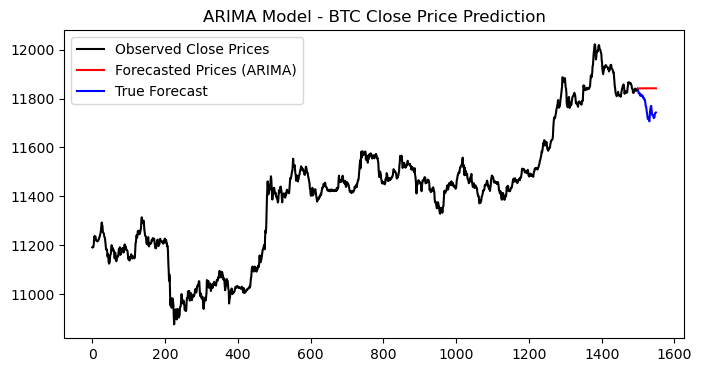

In [171]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

arima_model = ARIMA(x_sample_train, order = (2, 1, 2))
arima_result = arima_model.fit()

print(arima_result.summary())

forecast_arima = arima_result.get_forecast(steps = len(x_sample_test))
forecast_arima_values = forecast_arima.predicted_mean

xlin_1 = np.arange(0, len(x_sample_train))
xlin_2 = np.arange(len(x_sample_train), len(x_sample_train) + len(x_sample_test))

plt.figure(figsize=(8, 4))
plt.plot(xlin_1, x_sample_train, label='Observed Close Prices', color = 'black')
plt.plot(xlin_2, forecast_arima_values, label='Forecasted Prices (ARIMA)', color='red')
plt.plot(xlin_2, x_sample_test, label = 'True Forecast', color = 'blue')
plt.title('ARIMA Model - BTC Close Price Prediction')
plt.legend()
plt.show()


----

### Machine Learning Models (ANN and RNN)

#### Artificial/Dense Neural Nets (A/DNN) 

(3136, 72, 1) (3136,)
(3136, 72, 6) (3136,)
 -- One-Sample-Test -- 
Random:  1819
11255.756666666664


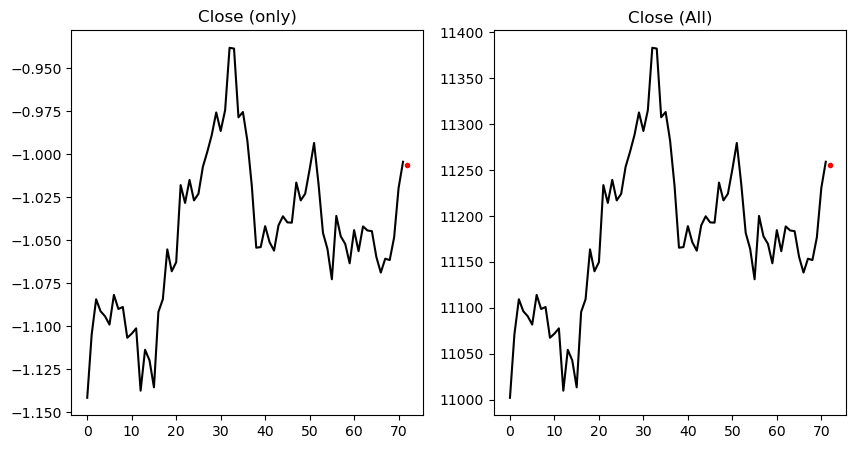

In [172]:
print(test_data_close.shape, test_target_close.shape)
print(test_data_all.shape, test_target_all.shape)

print(' -- One-Sample-Test -- ')

rn = random.randint(0, len(test_data_all))
print('Random: ', rn)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

idx_range = np.arange(len(test_data_close[rn]))
axs[0].plot(idx_range, test_data_close[rn], 'k')
axs[0].plot(idx_range[-1] + delay + 1, test_target_close[rn], '.r')
axs[0].set_title('Close (only)')

print(test_target_all[rn])
idx_range = np.arange(len(test_data_all[rn][:, -1]))
axs[1].plot(idx_range, test_data_all[rn][:, -1], 'k')
axs[1].plot(idx_range[-1] + delay + 1, test_target_all[rn], '.r')
axs[1].set_title('Close (All)')

plt.show()

In [173]:
from tensorflow.keras.layers import Normalization

keras_normalizer = Normalization()
keras_normalizer.adapt(train_data_all)

dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(72, train_data_all.shape[-1]), name = 'Input'),
    keras_normalizer,
    tf.keras.layers.Dense(64, activation = 'linear'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'linear')
    
])
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
dnn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 72, 6)            13        
 n)                                                              
                                                                 
 dense_25 (Dense)            (None, 72, 64)            448       
                                                                 
 dense_26 (Dense)            (None, 72, 128)           8320      
                                                                 
 dense_27 (Dense)            (None, 72, 256)           33024     
                                                                 
 dense_28 (Dense)            (None, 72, 128)           32896     
                                                                 
 dense_29 (Dense)            (None, 72, 64)            8256      
                                                        

In [174]:
ft = time.time()
dnn_hist = dnn_model.fit(train_data_all, train_target_all, epochs=50, validation_data = (val_data_all, val_target_all))#, callbacks=[es])
lt = time.time()

print('Training_Done ...  ')
print('Execution Time: ', (lt - ft)/60)

Epoch 1/50
849/849 [==============================] - 7s 4ms/step - loss: 10333243.0000 - mae: 1411.4463 - val_loss: 191480.5000 - val_mae: 356.9192
Epoch 2/50
849/849 [==============================] - 3s 4ms/step - loss: 83524.8438 - mae: 219.2487 - val_loss: 140802.3594 - val_mae: 307.7713
Epoch 3/50
849/849 [==============================] - 3s 4ms/step - loss: 75786.3906 - mae: 209.5439 - val_loss: 128450.5156 - val_mae: 291.5073
Epoch 4/50
849/849 [==============================] - 3s 4ms/step - loss: 69725.4219 - mae: 203.8208 - val_loss: 41982.2773 - val_mae: 158.0666
Epoch 5/50
849/849 [==============================] - 3s 4ms/step - loss: 54979.9023 - mae: 180.5186 - val_loss: 46160.7695 - val_mae: 173.2624
Epoch 6/50
849/849 [==============================] - 3s 4ms/step - loss: 47092.0977 - mae: 167.3867 - val_loss: 45273.6172 - val_mae: 173.3577
Epoch 7/50
849/849 [==============================] - 3s 4ms/step - loss: 42167.4688 - mae: 157.0955 - val_loss: 21214.3730 - val

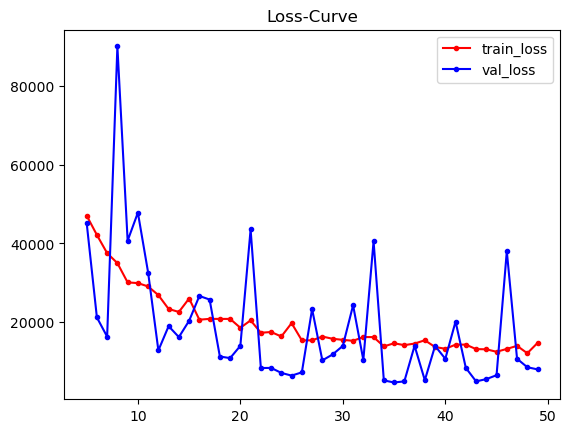

In [175]:
dnn_history = dnn_hist.history
epochs_arr = np.arange(len(dnn_history['loss']))

plt.plot(epochs_arr[5:], dnn_history['loss'][5:], label = 'train_loss', color = 'red', marker = '.')
plt.plot(epochs_arr[5:], dnn_history['val_loss'][5:], label = 'val_loss', color = 'blue', marker = '.')
plt.title('Loss-Curve')

plt.legend()
plt.show()

In [176]:
test_mae_err = dnn_model.evaluate(test_data_all, test_target_all, steps = 512)[-1]
print(f'The Absolute Error in Prediction of Close Price of BTC is {test_mae_err} USD, which is more than std-dev of Close Price in {sample_rate} minute time-frame chart')

512/512 [==============================] - 3s 4ms/step - loss: 8038.8535 - mae: 73.4238
The Absolute Error in Prediction of Close Price of BTC is 73.42383575439453 USD, which is more than std-dev of Close Price in 5 minute time-frame chart


random-seed:  762
(1, 72, 6) (1, 1)
1/1 [==============================] - 0s 240ms/step


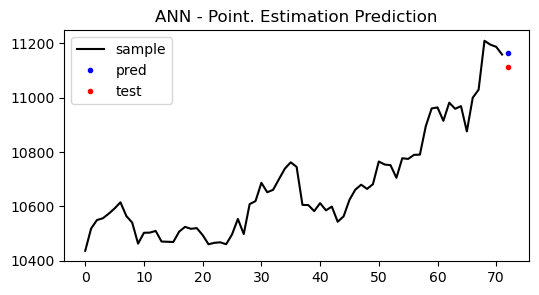

In [177]:
rn = random.randint(0, len(test_data_all))
print('random-seed: ', rn)
# rn = 2306

test_sample, test_target = test_data_all[rn].reshape(1, -1, test_data_all.shape[-1]), test_target_all[rn].reshape(-1, 1) 
print(test_sample.shape, test_target.shape)

test_pred = dnn_model.predict(test_sample)

# test_sample_descaled = np.squeeze(descale(test_sample, min_og, max_og))[:, -2]
# test_pred_descaled = descale(test_pred, min_og, max_og)[0][-2]
# test_target_descaled = descale(test_target, min_og, max_og)[0][-2]

# print(' --- descaled-Estimation --- ')
# print(test_pred_descaled.shape, test_target_descaled.shape)

fig = plt.figure(figsize=(6, 3))

x_lin = np.arange(0, len(np.squeeze(test_sample)[:, -2]))

plt.plot(x_lin, np.squeeze(test_sample)[:, -1], color = 'black', label = 'sample')
plt.plot(x_lin[-1] + delay + 1, test_pred[0][0], '.b', label = 'pred')
plt.plot(x_lin[-1] + delay + 1, test_target[0][0], '.r',  label = 'test')
plt.title('ANN - Point. Estimation Prediction')

plt.legend()
plt.show()

#### Recurrent Neural Nets (RNNs) 

In [178]:
keras_normalizer_rnn = Normalization()
keras_normalizer_rnn.adapt(train_data_all)

cnn_rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(72, train_data_all.shape[-1])),
    keras_normalizer_rnn,
    tf.keras.layers.Conv1D(64, 3),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.GRU(256, return_sequences=True),
    tf.keras.layers.GRU(256, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
]) 

cnn_rnn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
cnn_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 72, 6)            13        
 ion)                                                            
                                                                 
 conv1d (Conv1D)             (None, 70, 64)            1216      
                                                                 
 dense_32 (Dense)            (None, 70, 128)           8320      
                                                                 
 gru_16 (GRU)                (None, 70, 256)           296448    
                                                                 
 gru_17 (GRU)                (None, 70, 256)           394752    
                                                                 
 gru_18 (GRU)                (None, 128)               148224    
                                                      

In [179]:
ft = time.time()
cnn_rnn_hist = cnn_rnn_model.fit(train_data_all, train_target_all, epochs = 20, validation_data = (val_data_all, val_target_all))
lt = time.time()

print('Training_Done...')
print('Execution Time: ', (lt - ft)/60)

Epoch 1/50
849/849 [==============================] - 23s 18ms/step - loss: 140155632.0000 - mae: 11544.8242 - val_loss: 24085900.0000 - val_mae: 4858.7583
Epoch 2/50
849/849 [==============================] - 14s 17ms/step - loss: 17744212.0000 - mae: 3517.4229 - val_loss: 4465708.5000 - val_mae: 1996.8325
Epoch 3/50
849/849 [==============================] - 14s 17ms/step - loss: 2917152.5000 - mae: 1338.4458 - val_loss: 7049940.5000 - val_mae: 2563.5088
Epoch 4/50
849/849 [==============================] - 14s 16ms/step - loss: 1757293.5000 - mae: 904.7114 - val_loss: 452018.9688 - val_mae: 559.3390
Epoch 5/50
849/849 [==============================] - 14s 17ms/step - loss: 117563.0000 - mae: 195.4169 - val_loss: 139709.8281 - val_mae: 286.0277
Epoch 6/50
849/849 [==============================] - 14s 17ms/step - loss: 34730.0195 - mae: 105.8367 - val_loss: 40856.0820 - val_mae: 145.1416
Epoch 7/50
849/849 [==============================] - 14s 17ms/step - loss: 15639.4990 - mae: 78

KeyboardInterrupt: 

In [180]:
cnn_rnn_hist_history = cnn_rnn_hist.history 
epochs_arr = np.arange(len(cnn_rnn_hist_history['loss']))

plt.plot(epochs_arr[5:], cnn_rnn_hist_history['loss'][5:], label = 'train_loss', color = 'red', marker = '.')
plt.plot(epochs_arr[5:], cnn_rnn_hist_history['val_loss'][5:], label = 'val_loss', color = 'blue', marker = '.')
plt.title('Loss-Curve')

plt.legend()
plt.show()

NameError: name 'cnn_rnn_hist' is not defined

In [181]:
test_mae_err = cnn_rnn_model.evaluate(test_data_all, test_target_all, steps = 512)[-1]
print(f'The Absolute Error in Prediction of Close Price of BTC is {test_mae_err} USD, which is more than std-dev of Close Price in {sample_rate} minute time-frame chart')

512/512 [==============================] - 4s 6ms/step - loss: 14421.7881 - mae: 108.5999
The Absolute Error in Prediction of Close Price of BTC is 108.59992980957031 USD, which is more than std-dev of Close Price in 5 minute time-frame chart


random-seed:  3010
(1, 72, 6) (1, 1)
1/1 [==============================] - 0s 22ms/step


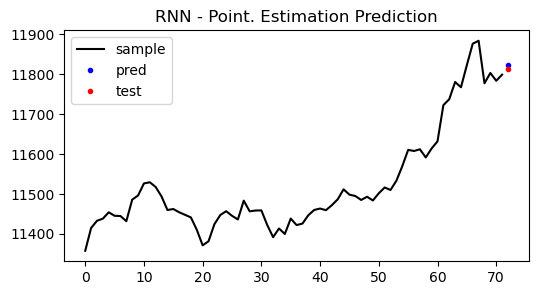

In [184]:
rn = random.randint(0, len(test_data_all))
print('random-seed: ', rn)
# rn = 2306

test_sample, test_target = test_data_all[rn].reshape(1, -1, test_data_all.shape[-1]), test_target_all[rn].reshape(-1, 1) 
print(test_sample.shape, test_target.shape)

test_pred = dnn_model.predict(test_sample)

fig = plt.figure(figsize=(6, 3))

x_lin = np.arange(0, len(np.squeeze(test_sample)[:, -2]))

plt.plot(x_lin, np.squeeze(test_sample)[:, -1], color = 'black', label = 'sample')
plt.plot(x_lin[-1] + delay + 1, test_pred[0][0], '.b', label = 'pred')
plt.plot(x_lin[-1] + delay + 1, test_target[0][0], '.r',  label = 'test')
plt.title('RNN - Point. Estimation Prediction')

plt.legend()
plt.show()

------------------------

### Bayesian Neural Networks (BNN) Workflow

In [55]:
hidden_units = [32, 16]
learning_rate = 0.001  
dataset_size = len(x_obs_close_scaled)
batch_size = 32

We are assuming that the posterior will follow a multivariate normal distribution, where the distribution of the learnable parameters is parameterized by the mean and covariance.

To represent the covariance matrix, we use a lower triangular matrix, which we then learn, instead of a full <code>n × n</code> covariance matrix. This is because of <b> Cholesky decomposition </b>, which states that any symmetric and positive definite covariance matrix can be written as the product of a lower triangular matrix and its transpose.

By learning the lower triangular matrix, we reduce computational complexity compared to learning the full covariance matrix.

In [56]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
        ]
    )
    return prior_model


def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            ## Student-t might be a better choice
            tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype), ## Creates trainable parameeters
            tfp.layers.MultivariateNormalTriL(n), ## Uses the trainable parameters to -> to create distrib. of weights
        ]
    )
    return posterior_model

In [57]:
def NLL(targets, est_distrib):
    return - est_distrib.log_prob(targets)

In [88]:
det_units = [128, 64, 64, 32]

#### Only Supplying the BTC Closing Price - NOT multi-feature Space
def create_bnn_model(train_size):

    inputs = tf.keras.layers.Input(shape = train_data_close.shape[1:])
    x = tf.keras.layers.Dense(det_units[0], activation = 'tanh')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GRU(det_units[1], activation = 'tanh', return_sequences = True)(x)
    x = tf.keras.layers.LayerNormalization()(x)    
    x = tf.keras.layers.GRU(det_units[2], activation = 'tanh', return_sequences = False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(det_units[-1], activation = 'sigmoid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        x = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight = 1 / train_size,
            activation="sigmoid",
        )(x)

    # The output is deterministic: a single point estimate | Distribution.
    ''' Distrib. Output | Independent Normal (Gaussian) distributions for each element in the data (Probabilistic) '''
    x = tf.keras.layers.Dense(units=2)(x) # |meu, Sigma| --> N_distrib 
    outputs = tfp.layers.IndependentNormal(1)(x)

    ''' Deterministic Output (Point Estimation) '''
#     outputs = tf.keras.layers.Dense(units=1)(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


train_dataset = tf.data.Dataset.from_tensor_slices((train_data_close, train_target_close)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data_close, val_target_close)).batch(batch_size)
tf.print(train_dataset, val_dataset)

loss = tf.keras.losses.MSE

bnn_model = create_bnn_model(dataset_size)
bnn_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss = loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

bnn_model.summary()

<_BatchDataset element_spec=(TensorSpec(shape=(None, 72, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 72, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 72, 1)]           0         
                                                                 
 dense_22 (Dense)            (None, 72, 128)           256       
                                                                 
 batch_normalization_14 (Bat  (None, 72, 128)          512       
 chNormalization)                                                
                                                                 
 gru_14 (GRU)                (None, 72, 64)            37248     
                           

In [89]:
num_epochs = 30

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

print("Start training the model...")

ft = time.time()

hist_values = bnn_model.fit(train_dataset, epochs=num_epochs, validation_data = val_dataset, callbacks = [es])

lt = time.time()

print(f"Model training finished in {(lt - ft) / 60} mins")

Start training the model...
Epoch 1/30
849/849 [==============================] - 22s 18ms/step - loss: 1.0731 - root_mean_squared_error: 1.0326 - val_loss: 2.0791 - val_root_mean_squared_error: 1.4387
Epoch 2/30
849/849 [==============================] - 14s 17ms/step - loss: 0.8516 - root_mean_squared_error: 0.9167 - val_loss: 2.0666 - val_root_mean_squared_error: 1.4329
Epoch 3/30
849/849 [==============================] - 14s 16ms/step - loss: 0.8288 - root_mean_squared_error: 0.9020 - val_loss: 1.8974 - val_root_mean_squared_error: 1.3712
Epoch 4/30
849/849 [==============================] - 14s 17ms/step - loss: 0.7578 - root_mean_squared_error: 0.8593 - val_loss: 1.6530 - val_root_mean_squared_error: 1.2773
Epoch 5/30
849/849 [==============================] - 14s 16ms/step - loss: 0.5556 - root_mean_squared_error: 0.7293 - val_loss: 0.9903 - val_root_mean_squared_error: 0.9821
Epoch 6/30
849/849 [==============================] - 14s 16ms/step - loss: 0.4147 - root_mean_squared

### Point-Estimate

In [90]:
data_dict = {}

data_dict['train'] = [train_data_close, train_target_close]
data_dict['val'] = [val_data_close, val_target_close]
data_dict['test'] = [test_data_close, test_target_close]

(300,) (300,) (300,) (300,) (300,) (300, 3)
time-taken:  0.028961006800333658 mins


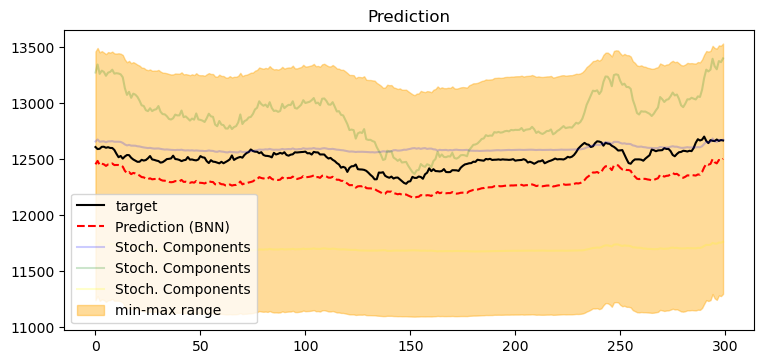

In [84]:
_rate = 300

def Pred_Plot(pred_data, pred_target):

    _ran = min(len(pred_data), 300)
    
    iterations = 10
    
    x_lin = np.arange(0, _ran) 

    predicted = []
    
    for _ in range(iterations):
        predicted.append(bnn_model(pred_data[:_ran]).numpy())
    
    predicted = np.concatenate(predicted, axis=1)
    
    ## intermediate stochastic components
    _st = 3
    predicted_three = predicted[:, _st : _st + (_rate//100)] 

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()
    
    inv_test_pred = prediction_mean
    inv_test_target = pred_target[:_ran]
    lower = prediction_min
    upper = prediction_max
    predicted_three = predicted_three

    return x_lin, inv_test_pred, inv_test_target, lower, upper, predicted_three


fig, axs = plt.subplots(1, 1, figsize=(8, 4))

names = list(data_dict.keys())

ft = time.time()

_color = ['blue', 'green', 'yellow']

for i, nm in enumerate(names[1:2]):
    
    k_st = 0
    x_lin, inv_p, inv_t, lower, upper, p_three = Pred_Plot(data_dict[nm][0], data_dict[nm][-1])
    
    if i == 0:
        print(x_lin.shape, np.array(inv_p).shape, np.array(inv_t).shape, np.array(lower).shape, np.array(upper).shape, p_three.shape)
    
    inv_t = scaler_close.inverse_transform(np.array(inv_t).reshape(-1, 1))
    inv_p = scaler_close.inverse_transform(np.array(inv_p).reshape(-1, 1))
    lower = scaler_close.inverse_transform(np.array(lower).reshape(-1, 1)).reshape(len(lower), )
    upper = scaler_close.inverse_transform(np.array(upper).reshape(-1, 1)).reshape(len(upper), )
    p_three = scaler_close.inverse_transform(p_three)
    
    axs.plot(x_lin, inv_t, 'k', label = 'target')
    axs.plot(x_lin, inv_p, 'r--',  label = 'Prediction (BNN)')
    
    for step, c in enumerate(_color):
        axs.plot(x_lin, p_three[:, step], color = c, alpha = 0.2, label = 'Stoch. Components')

    axs.fill_between(x_lin, lower, upper, color='orange', alpha=0.4, label = 'min-max range')
    axs.set_title('Prediction')
    axs.legend()
    
lt = time.time()
 
print('time-taken: ', (lt - ft)/60, 'mins')

plt.tight_layout(pad = 2)
plt.show()

In [87]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_close, test_target_close))
mse_error, rmse_error = bnn_model.evaluate(test_data_close, test_target_close)

print("MSE-Error (normalized): ", mse_error, ", RMSE-Error (normalized):",rmse_error)

98/98 [==============================] - 2s 7ms/step - loss: 0.1358 - root_mean_squared_error: 0.2923
MSE-Error (normalized):  0.13581199944019318 , RMSE-Error (normalized): 0.2922823131084442


### Probabilistic

(3136, 72, 1) (3136,)


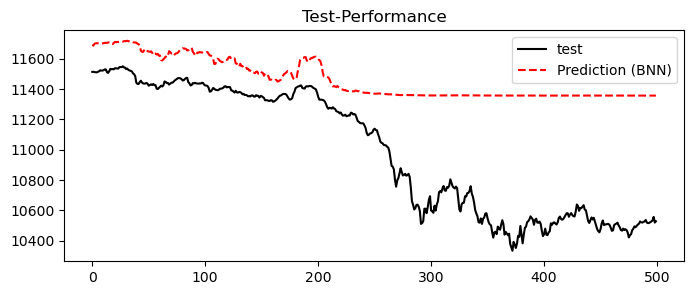

In [167]:
pred_data = test_data_close
pred_target = test_target_close

print(pred_data.shape, pred_target.shape)

ci = 0.675
max_predict = 500

_ran = min(len(pred_data), max_predict)

x_lin = np.arange(0, _ran) 

## Just samples a value at each t from the surrogate posterior distrb.
prediction_distribution = bnn_model(pred_data[:_ran]) ### Gives stochastic value at each time-step (i,e n random variables for n t-steps) for each run
prediction_mean = prediction_distribution.mean().numpy().tolist() ### We get a distribution object, giving seperate distributions for each-time step  
prediction_stdv = prediction_distribution.stddev().numpy()

inv_test_pred = scaler_close.inverse_transform(prediction_mean)
inv_test_target = scaler_close.inverse_transform(pred_target[:_ran].reshape(-1, 1))

# The 75% CI 
upper = (prediction_mean + (ci * prediction_stdv)).tolist()
lower = (prediction_mean - (ci * prediction_stdv)).tolist()

upper = np.array(upper).reshape(-1, 1)
lower = np.array(lower).reshape(-1, 1) 

upper = scaler_close.inverse_transform(upper).reshape(len(upper), )
lower = scaler_close.inverse_transform(lower).reshape(len(lower), )

fig = plt.figure(figsize=(8, 3))
plt.plot(x_lin, inv_test_target, 'k', label = 'test')
plt.plot(x_lin, inv_test_pred, 'r--',  label = 'Prediction (BNN)')
# plt.fill_between(x_lin, lower, upper, color='orange', alpha=0.5, label = '75% CI')
plt.title('Test-Performance')

plt.legend()
plt.show()

In [108]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_close, test_target_close))
mse_error, rmse_error = bnn_model.evaluate(test_data_close, test_target_close)

print("MSE-Error: ", mse_error, ", RMSE-Error:",rmse_error)

98/98 [==============================] - 1s 7ms/step - loss: 0.1027 - root_mean_squared_error: 0.2318
MSE-Error:  0.1026824414730072 , RMSE-Error: 0.2318204641342163


---

SESSION STOPPER

In [ ]:
import time
for i in range(50):
    print('Time: ', i)
    time.sleep(30*60)